In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
import pickle
import joblib
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV


In [48]:
# Load Dataset
import os
from google.cloud import storage

# Define your GCS bucket and the key file path
bucket_name = 'g2-finalproject'
key_file_path = 'Credential/vertex.json'
local_key_path = '/tmp/service-account-file.json'

# Initialize a client
storage_client = storage.Client()

# Download the key file from GCS
bucket = storage_client.bucket(bucket_name)
blob = bucket.blob(key_file_path)
blob.download_to_filename(local_key_path)

# Set the environment variable
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = local_key_path

# Verify the environment variable is set correctly
print(f"GOOGLE_APPLICATION_CREDENTIALS is set to: {os.getenv('GOOGLE_APPLICATION_CREDENTIALS')}")

from google.colab import auth
from google.cloud import bigquery

# Set up the BigQuery client
project_id = 'finalproject-g2df12'
client = bigquery.Client(project=project_id, location="asia-southeast2")

# Load data from BigQuery
query = """
SELECT *
FROM `finalproject-g2df12.retail.raw_dataiku`
"""

# Load data into a DataFrame
data_raw = client.query(query).to_dataframe()

GOOGLE_APPLICATION_CREDENTIALS is set to: /tmp/service-account-file.json


In [94]:
data_raw.dtypes
data.dtypes

InvoiceNo              object
StockCode              object
Description            object
Quantity                Int64
InvoiceDate    datetime64[us]
UnitPrice             float64
CustomerID             object
Country                object
TotalPrice            Float64
dtype: object

In [151]:
# Data Preprocessing
# Drop records with null value in CustomerID
data = data_raw.dropna(subset=['CustomerID'])
data = data[~data['InvoiceNo'].str.startswith('C')]
data['TotalPrice'] = data['Quantity'] * data['UnitPrice']
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])
#data['CustomerID'] = data['CustomerID'].astype(int)

<ipython-input-151-a3c030e3a7ba>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['TotalPrice'] = data['Quantity'] * data['UnitPrice']


In [152]:
# Set threshold period (pre:dec10-aug11, post:sep11-dec11)
n_days = 90
max_date = data['InvoiceDate'].max()
cutoff_date = max_date - pd.to_timedelta(n_days, unit = "d")

past_data = data[data['InvoiceDate'] < cutoff_date]
future_data = data[data['InvoiceDate'] >= cutoff_date]

In [58]:
from pandas_gbq import read_gbq, to_gbq

# Set your project ID and table details
project_id = 'finalproject-g2df12'
dataset_id = 'retail'
table_id = 'prediction_data'
table_full_id = f'{project_id}.{dataset_id}.{table_id}'

client = bigquery.Client(project=project_id)

# Write the updated DataFrame back to BigQuery
to_gbq(future_data, table_full_id, project_id=project_id, if_exists='replace')

100%|██████████| 1/1 [00:00<00:00, 8612.53it/s]


In [154]:
# RFM Segmentation all customers
now = data['InvoiceDate'].max() + pd.Timedelta(days=1)

rfm = data.groupby('CustomerID').agg({
    'InvoiceDate': lambda date: (now - date.max()).days,
    'InvoiceNo': lambda num: len(num),
    'Quantity': lambda quant: quant.sum(),
    'TotalPrice': lambda price: price.sum()
})

# Rename columns
rfm.columns = ['Recency', 'Frequency', 'Density', 'Monetary']
rfm = rfm.reset_index()

In [128]:
# RFM Pre-Threshold data
now = past_data['InvoiceDate'].max() + pd.Timedelta(days=1)

rfm = past_data.groupby('CustomerID').agg({
    'InvoiceDate': lambda date: (now - date.max()).days,
    'InvoiceNo': lambda num: len(num),
    'Quantity': lambda quant: quant.sum(),
    'TotalPrice': lambda price: price.sum()
})

# Rename columns
rfm.columns = ['Recency', 'Frequency', 'Density', 'Monetary']
rfm = rfm.reset_index()

# #Define RFM score calculation
# rfm['R_Score'] = pd.qcut(rfm['Recency'], 5, labels=[5, 4, 3, 2, 1], duplicates='drop')
# rfm['F_Score'] = pd.qcut(rfm['Frequency'], 5, labels=[1, 2, 3, 4, 5], duplicates='drop')
# rfm['D_Score'] = pd.qcut(rfm['Density'], 5, labels=[1, 2, 3, 4, 5], duplicates='drop')
# rfm['M_Score'] = pd.qcut(rfm['Monetary'], 5, labels=[1, 2, 3, 4, 5], duplicates='drop')

# #Calculate RFM score
# rfm['RFM_Score'] = (rfm['R_Score'].astype(str) + rfm['F_Score'].astype(str) + rfm['M_Score'].astype(str)).astype(int)

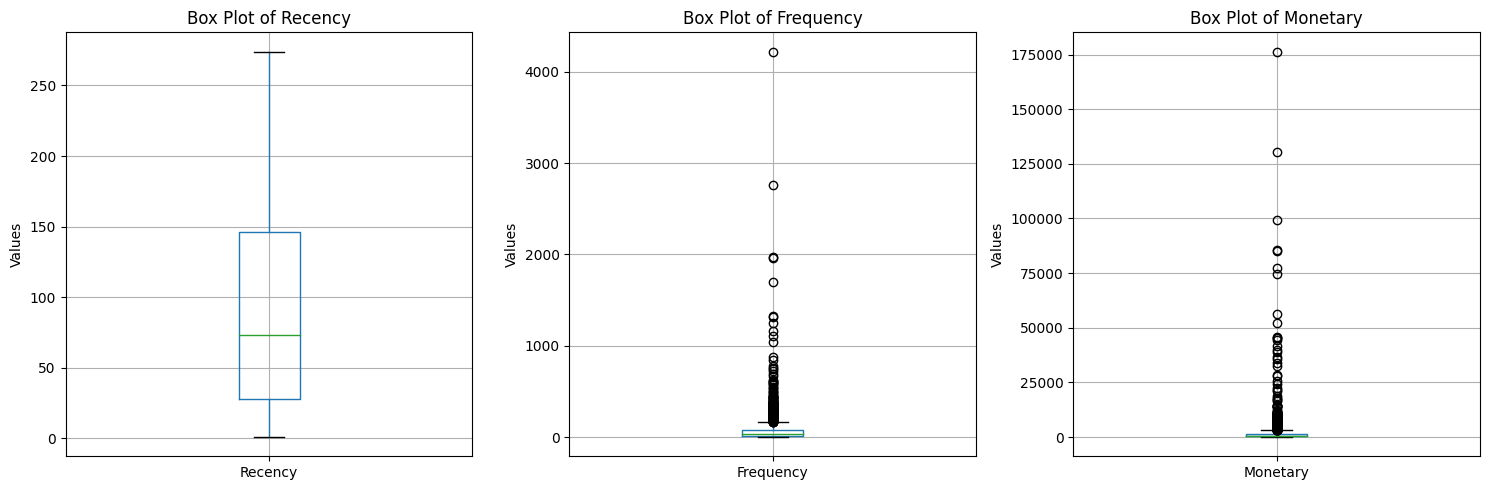

In [139]:
# Specify the columns to plot
columns_to_plot = ['Recency', 'Frequency', 'Monetary']

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

# Create individual box plots for each column
for i, col in enumerate(columns_to_plot):
    rfm_copy.boxplot(column=col, ax=axes[i])
    axes[i].set_title(f'Box Plot of {col}')
    axes[i].set_ylabel('Values')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

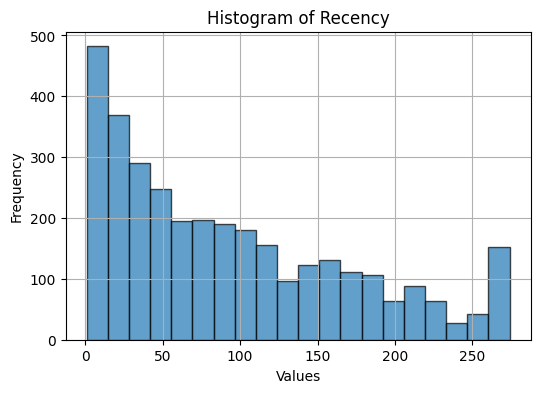

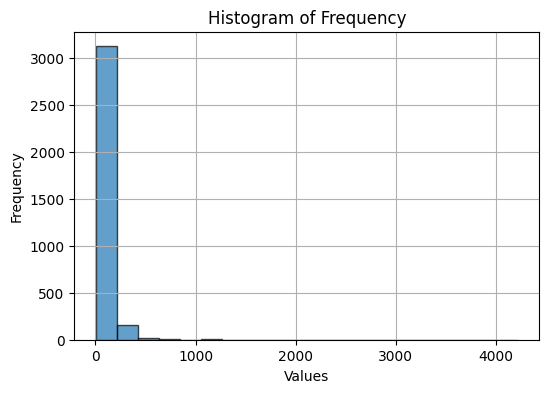

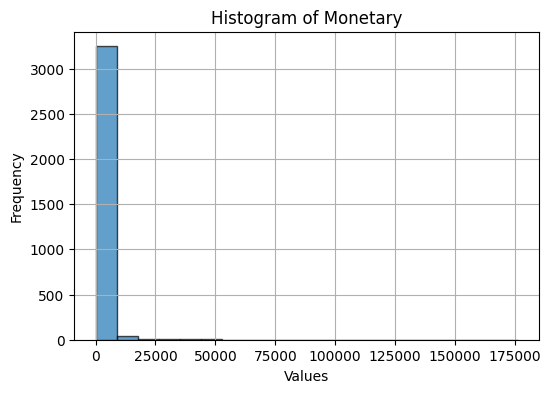

In [140]:
for col in columns_to_plot:
    plt.figure(figsize=(6, 4))
    plt.hist(rfm_copy[col], bins=20, edgecolor='k', alpha=0.7)
    plt.title(f'Histogram of {col}')
    plt.xlabel('Values')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

In [155]:
quantiles = rfm["Recency"].quantile(q = [0.2, 0.4, 0.6, 0.8, 1.0])
a,b,c,d,e = quantiles

def recency_scoring(data):
    if data["Recency"] <= a:
        return 1
    elif data["Recency"] <= b:
        return 2
    elif data["Recency"] <= c:
        return 3
    elif data["Recency"] <= d:
        return 4
    else:
        return 5

quantiles = rfm["Density"].quantile(q = [0.2, 0.4, 0.6, 0.8, 1.0])
a,b,c,d,e = quantiles

def density_scoring(data):
    if data["Density"] <= a:
        return 1
    elif data["Density"] <= b:
        return 2
    elif data["Density"] <= c:
        return 3
    elif data["Density"] <= d:
        return 4
    else:
        return 5

quantiles = rfm["Frequency"].quantile(q = [0.2, 0.4, 0.6, 0.8, 1.0])
a,b,c,d,e = quantiles

def frequency_scoring(data):
    if data["Frequency"] <= a:
        return 1
    elif data["Frequency"] <= b:
        return 2
    elif data["Frequency"] <= c:
        return 3
    elif data["Frequency"] <= d:
        return 4
    else:
        return 5

quantiles = rfm["Monetary"].quantile(q = [0.2, 0.4, 0.6, 0.8, 1.0])
a,b,c,d,e = quantiles

def monetary_scoring(data):
    if data["Monetary"] <= a:
        return 1
    elif data["Monetary"] <= b:
        return 2
    elif data["Monetary"] <= c:
        return 3
    elif data["Monetary"] <= d:
        return 4
    else:
        return 5

rfm['R_Score'] = rfm.apply(recency_scoring, axis =1)
rfm['F_Score'] = rfm.apply(frequency_scoring, axis =1)
rfm['D_Score'] = rfm.apply(density_scoring, axis =1)
rfm['M_Score'] = rfm.apply(monetary_scoring, axis =1)

In [13]:
# no need to run
print(rfm["Recency"].quantile(q = [0.2, 0.4, 0.6, 0.8, 1.0]))
print(rfm["Frequency"].quantile(q = [0.2, 0.4, 0.6, 0.8, 1.0]))
print(rfm["Density"].quantile(q = [0.2, 0.4, 0.6, 0.8, 1.0]))
print(rfm["Monetary"].quantile(q = [0.2, 0.4, 0.6, 0.8, 1.0]))

0.25     26.0
0.50     74.0
0.75    151.0
Name: Recency, dtype: float64
0.25    15.0
0.50    33.0
0.75    77.0
Name: Frequency, dtype: float64
0.25     132.0
0.50     314.0
0.75    783.75
Name: Density, dtype: Float64
0.25        266.1
0.50       565.96
0.75    1388.9375
Name: Monetary, dtype: Float64


In [10]:
# no need to run
def recency_scoring(data):
    if data["Recency"] <= 26:
        return 1
    elif data["Recency"] <= 74:
        return 2
    elif data["Recency"] <= 151:
        return 3
    else:
        return 4

def frequency_scoring(data):
    if data.Frequency <= 14:
        return 1
    elif data.Frequency <= 33:
        return 2
    elif data.Frequency <= 77:
        return 3
    else:
        return 4

def density_scoring(data):
    if data.Density <= 122:
        return 1
    elif data.Density <= 290.5:
        return 2
    elif data.Density <= 743.25:
        return 3
    else:
        return 4

def monetary_scoring(data):
    if data.Monetary <= 243.63:
        return 1
    elif data.Monetary <= 532.96:
        return 2
    elif data.Monetary <= 1311.285:
        return 3
    else:
        return 4

def density_scoring(data):
    if data.Density <= 298.185:
        return 1
    elif data.Density <= 644.975:
        return 2
    elif data.Density <= 1571.3575:
        return 3
    else:
        return 4

rfm['R_Score'] = rfm.apply(recency_scoring, axis =1)
rfm['F_Score'] = rfm.apply(frequency_scoring, axis =1)
rfm['D_Score'] = rfm.apply(density_scoring, axis =1)
rfm['M_Score'] = rfm.apply(monetary_scoring, axis =1)

rfm.head()

,CustomerID,Recency,Frequency,Density,Monetary,R_Score,F_Score,D_Score,M_Score
0,12346,226,2,0,0.0,4,1,1,1
1,12347,30,124,1590,2790.86,2,4,4,4
2,12348,149,28,2124,1487.24,4,2,4,4
3,12350,211,17,197,334.4,4,2,1,2
4,12352,163,48,188,601.18,4,3,1,3


In [156]:
def rfm_scoring(data):
    return str(int(data['R_Score'])) + str(int(data['F_Score'])) + str(int(data['M_Score']))

rfm['RFM_Score'] = rfm.apply(rfm_scoring, axis=1).astype(int)
rfm.head()

,CustomerID,Recency,Frequency,Density,Monetary,R_Score,F_Score,D_Score,M_Score,RFM_Score
0,12346,326,1,74215,77183.6,2,1,5,5,215
1,12347,2,182,2458,4310.0,1,1,5,5,115
2,12348,75,31,2341,1797.24,1,1,5,4,114
3,12349,19,73,631,1757.55,1,1,3,4,114
4,12350,310,17,197,334.4,2,1,1,2,212


In [157]:
rfm['rfm_level'] = (rfm['R_Score'] + rfm['F_Score'] + rfm['M_Score']).astype(int)

In [134]:
rfm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3370 entries, 0 to 3369
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   CustomerID  3370 non-null   object 
 1   Recency     3370 non-null   int64  
 2   Frequency   3370 non-null   int64  
 3   Density     3370 non-null   Int64  
 4   Monetary    3370 non-null   Float64
 5   R_Score     3370 non-null   int64  
 6   F_Score     3370 non-null   int64  
 7   D_Score     3370 non-null   int64  
 8   M_Score     3370 non-null   int64  
 9   RFM_Score   3370 non-null   int64  
 10  rfm_level   3370 non-null   int64  
dtypes: Float64(1), Int64(1), int64(8), object(1)
memory usage: 296.3+ KB


In [135]:
rfm.describe()

,Recency,Frequency,Density,Monetary,R_Score,F_Score,D_Score,M_Score,RFM_Score,rfm_level
count,3370.000000,3370.000000,3370.0,3370.0,3370.000000,3370.000000,3370.000000,3370.000000,3370.000000,3370.000000
mean,94.884866,70.142136,952.662018,1618.814594,1.107418,1.079525,2.380119,3.000000,124.537092,5.186944
std,79.986125,147.831951,3836.400054,6151.394333,0.309690,0.357545,1.393287,1.414423,30.622889,1.510842
min,1.000000,1.000000,1.0,2.9,1.000000,1.000000,1.000000,1.000000,111.000000,3.000000
25%,26.000000,15.000000,132.0,266.1,1.000000,1.000000,1.000000,2.000000,112.000000,4.000000
50%,74.000000,33.000000,314.0,565.96,1.000000,1.000000,2.000000,3.000000,113.000000,5.000000
75%,151.000000,77.000000,783.75,1388.9375,1.000000,1.000000,4.000000,4.000000,115.000000,6.000000
max,283.000000,4490.000000,128320.0,178302.62,2.000000,5.000000,5.000000,5.000000,225.000000,11.000000


In [158]:
quantiles = rfm["rfm_level"].quantile(q = [0.1, 0.6, 1.0])
a,b,c = quantiles

def value_segment(data):
    if data["rfm_level"] <= a:
        return 'Low'
    elif data["rfm_level"] <= b:
        return 'Mid'
    else:
        return 'High'

rfm['Segment'] = rfm.apply(value_segment, axis =1)

In [ ]:
# no need to run
def segments1(data):
    if data['rfm_level'] >= 9 :
        return 'High'
    elif (data['rfm_level'] >= 6) and (data['rfm_level'] < 9 ):
        return 'Middle'
    else:
        return 'Low'

rfm ['Segment'] = rfm.apply(segments1,axis=1)
rfm.head()

,CustomerID,Recency,Frequency,Density,Monetary,R_Score,F_Score,D_Score,M_Score,RFM_Score,rfm_level,Segment
0,12346,226,2,0,0.0,4,1,1,1,411,6,Middle
1,12347,30,124,1590,2790.86,2,4,4,4,244,10,High
2,12348,149,28,2124,1487.24,4,2,4,4,424,10,High
3,12350,211,17,197,334.4,4,2,1,2,422,8,Middle
4,12352,163,48,188,601.18,4,3,1,3,433,10,High


In [ ]:
# no need to run
# Calculate quantiles for segmentation
quantiles = rfm['RFM_Score'].quantile([0.33, 0.66]).values

# Define a function to assign segments based on quantiles
def segment_rfm(score):
    if score <= quantiles[0]:
        return 'Low'
    elif score <= quantiles[1]:
        return 'Mid'
    else:
        return 'High'

# Apply the segmentation function
rfm['Segment'] = rfm['RFM_Score'].apply(segment_rfm)

In [159]:
rfm_map = {
    r'[45]{3}': 'Champions',
    r'[345]{3}': 'Loyal Customers',
    r'[345][2345][123]': 'Potential Loyalist',
    r'[345][12][12]': 'New Customers',
    r'[345][125][12345]': 'Promising',
    r'[345][234][345]': 'Need Attention',
    r'[23][12345]1': 'About to Sleep',
    r'[12][145][345]': 'Cannot Lose',
    r'[123][2345][2345]': 'At Risk',
    r'[123][123][23]': 'Hibernating',
    r'1[12345][12]': 'Lost Customers'
}

rfm['RFM_Score'] = rfm['RFM_Score'].replace(rfm_map, regex=True)

# Creation of Segment Variable
rfm['RFM_Segment'] = rfm['R_Score'].astype(str) + rfm['F_Score'].astype(str) + rfm['M_Score'].astype(str)
rfm['RFM_Segment'] = rfm['RFM_Segment'].replace(rfm_map, regex=True)

In [ ]:
# no need to run
def categorizer(rfm):
    if (rfm[0] in ['3', '4']) & (rfm[1] in ['3', '4']) & (rfm[2] in ['3', '4']):
        rfm = 'Champions'
    elif (rfm[0] in ['2', '3', '4']) & (rfm[1] in ['3', '4']) & (rfm[2] in ['1', '2', '3', '4']):
        rfm = 'Loyal Customers'
    elif (rfm[0] in ['3', '4']) & (rfm[1] in ['2', '3']) & (rfm[2] in ['1', '2', '3', '4']):
        rfm = 'Potential Loyalist'
    elif (rfm[0] in ['4']) & (rfm[1] in ['1']) & (rfm[2] in ['1', '2', '3', '4']):
        rfm = 'Recent Customers'
    elif (rfm[0] in ['2', '3']) & (rfm[1] in ['2', '3']) & (rfm[2] in ['2', '3']):
        rfm = 'Customers Needing Attention'
    elif (rfm[0] in ['2', '3']) & (rfm[1] in ['1', '2']) & (rfm[2] in ['1', '2', '3', '4']):
        rfm = 'Still Got Hope'
    elif (rfm[0] in ['1', '2']) & (rfm[1] in ['3', '4']) & (rfm[2] in ['2', '3', '4']):
        rfm = 'Need to Get Them Back'
    elif (rfm[0] in ['1', '2']) & (rfm[1] in ['1', '2']) & (rfm[2] in ['1', '2']):
        rfm = 'Lost'
    elif (rfm[0] in ['1', '2']) & (rfm[1] in ['1', '2', '3']) & (rfm[2] in ['1', '2', '3', '4']):
        rfm = 'Give it a Try'
    return rfm

rfm['RFM_Segment'] = rfm["RFM_Score"].apply(categorizer)
rfm.head()

# seg_map = {
#     r'[1-2][1-2]': 'Hibernating',
#     r'[1-2][3-4]': 'At Risk',
#     r'[1-2]5': 'Cant Lose',
#     r'3[1-2]': 'About to Sleep',
#     r'33': 'Need Attention',
#     r'[3-4][4-5]': 'Loyal Customers',
#     r'41': 'Promising',
#     r'51': 'New Customers',
#     r'[4-5][2-3]': 'Potential Loyalists',
#     r'5[4-5]': 'Champions'
# }

seg_map = {
    r'[1-2][1-4]': 'Hibernating',
    r'[1-2][3-4]': 'At Risk',
    r'[1-2]4': 'Cant Lose',
    r'3[1-2]': 'About to Sleep',
    r'33': 'Need Attention',
    r'[3-4][2-4]': 'Loyal Customers',
    r'41': 'Promising',
    r'44': 'New Customers',
    r'[4-5][2-3]': 'Potential Loyalists'
}

rfm['RFM_Score'] = rfm['RFM_Score'].replace(seg_map, regex=True)

# Creation of Segment Variable
rfm['RF_Segment'] = rfm['R_Score'].astype(str) + rfm['F_Score'].astype(str)
rfm['RF_Segment'] = rfm['RF_Segment'].replace(seg_map, regex=True)

In [105]:
rfm.head()

,CustomerID,Recency,Frequency,Density,Monetary,R_Score,F_Score,D_Score,M_Score,RFM_Score,rfm_level,Segment,RFM_Segment
0,12346,235,1,74215,77183.6,2,1,5,5,215,8,High,Cannot Lose
1,12347,39,124,1590,2790.86,1,1,4,5,115,7,High,Cannot Lose
2,12348,158,28,2124,1487.24,1,1,5,4,114,6,Mid,Cannot Lose
3,12350,219,17,197,334.4,2,1,1,2,212,5,Mid,Hibernating
4,12352,171,38,254,1561.81,1,1,2,4,114,6,Mid,Cannot Lose


In [ ]:
def rfm_scoring(data):
    return str(int(data['R_Score'])) + str(int(data['F_Score'])) + str(int(data['M_Score']))

rfm['RFM_Score'] = rfm.apply(rfm_scoring, axis=1)
rfm.head()

,CustomerID,Recency,Frequency,Density,Monetary,R_Score,F_Score,D_Score,M_Score,RFM_Score,rfm_level,Segment,RFM_Segment,RF_Segment
0,12346,226,2,0,0.0,4,1,1,1,411,6,Middle,Recent Customers,Promising
1,12347,30,124,1590,2790.86,2,4,4,4,244,10,High,Loyal Customers,Hibernating
2,12348,149,28,2124,1487.24,4,2,4,4,424,10,High,Potential Loyalist,Loyal Customers
3,12350,211,17,197,334.4,4,2,1,2,422,8,Middle,Potential Loyalist,Loyal Customers
4,12352,163,48,188,601.18,4,3,1,3,433,10,High,Champions,Loyal Customers


In [161]:
rfm = rfm.copy()
# Calculate the CLV of each customer
rfm['AOV'] = rfm['Monetary'] / rfm['Frequency']

# Calculate Purchase Frequency
purchase_frequency = rfm['Frequency'].sum() / rfm['CustomerID'].nunique()

# Calculate Retention Rate
retention_rate = rfm[rfm.Frequency > 1].shape[0] / rfm.shape[0]

# Calculate Churn Rate
churn_rate = 1 - retention_rate

# Calculate CLV
rfm['profit_margin'] = rfm['Monetary'] * 0.1
rfm['CLV'] = ((rfm['AOV'] * purchase_frequency) / churn_rate) * rfm['profit_margin']

,CustomerID,Recency,Frequency,Density,Monetary,R_Score,F_Score,D_Score,M_Score,RFM_Score,rfm_level,Segment,RFM_Segment,AOV,profit_margin,CLV
0,12346,326,1,74215,77183.6,2,1,5,5,215,8,High,Cannot Lose,77183.6,7718.36,3292438711041.379883
1,12347,2,182,2458,4310.0,1,1,5,5,115,7,High,Cannot Lose,23.681319,431.0,56409310.259463
2,12348,75,31,2341,1797.24,1,1,5,4,114,6,Mid,Cannot Lose,57.975484,179.724,57586156.736642
3,12349,19,73,631,1757.55,1,1,3,4,114,6,Mid,Cannot Lose,24.076027,175.755,23386226.68118
4,12350,310,17,197,334.4,2,1,1,2,212,5,Mid,Hibernating,19.670588,33.44,3635392.051033
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4334,18280,278,10,45,180.6,2,1,1,1,211,4,Mid,About to Sleep,18.06,18.06,1802615.6162
4335,18281,181,7,54,80.82,1,1,1,1,111,3,Low,Lost Customers,11.545714,8.082,515712.062083
4336,18282,8,12,103,178.05,1,1,1,1,111,3,Low,Lost Customers,14.8375,17.805,1460058.80301
4337,18283,4,756,1397,2094.88,1,3,4,5,135,9,High,At Risk,2.771005,209.488,3208220.005958


In [140]:
# Calculate Future CLV based on post-cutoff data
future_rfm = future_data.groupby('CustomerID').agg({
    'InvoiceNo': lambda num: len(num),
    'Quantity': lambda quant: quant.sum(),
    'TotalPrice': lambda price: price.sum()
})

# Rename columns
future_rfm.columns = ['Frequency', 'Density', 'Monetary']
future_rfm = future_rfm.reset_index()

# Calculate the CLV of each customer
future_rfm['AOV'] = future_rfm['Monetary'] / future_rfm['Frequency']

# Calculate Purchase Frequency
future_purchase_frequency = future_rfm['Frequency'].sum() / future_rfm['CustomerID'].nunique()

# Calculate Retention Rate
future_retention_rate = future_rfm[future_rfm.Frequency > 1].shape[0] / future_rfm.shape[0]

# Calculate Churn Rate
future_churn_rate = 1 - future_retention_rate

# Calculate CLV
future_rfm['future_profit_margin'] = future_rfm['Monetary'] * 0.1
future_rfm['FutureCLV'] = ((future_rfm['AOV'] * future_purchase_frequency) / future_churn_rate) * future_rfm['future_profit_margin']

In [141]:
future_revenue = future_data.groupby('CustomerID')['TotalPrice'].sum().reset_index()
future_revenue.columns = ['CustomerID', 'FutureRevenue']

rfm = rfm.merge(future_revenue, on='CustomerID', how='left')
rfm['FutureRevenue'] = rfm['FutureRevenue'].fillna(0)

future_clv = future_rfm.drop(columns=['Frequency', 'Density', 'Monetary', 'AOV', 'future_profit_margin'], axis=1)
rfm = rfm.merge(future_clv, on='CustomerID', how='left')
rfm['FutureCLV'] = rfm['FutureCLV'].fillna(0)

In [142]:
future_rfm = future_data.groupby('CustomerID').agg({
    'InvoiceNo': lambda num: len(num),
    'Quantity': lambda quant: quant.sum(),
    'TotalPrice': lambda price: price.sum()
})

# Rename columns
future_rfm.columns = ['Frequency', 'Density', 'Monetary']
future_rfm = future_rfm.reset_index()

# Calculate the CLV of each customer
future_rfm['AOV'] = future_rfm['Monetary'] / future_rfm['Frequency']

# Calculate Purchase Frequency
future_purchase_frequency = future_rfm['Frequency'].sum() / future_rfm['CustomerID'].nunique()

# Calculate Retention Rate
future_retention_rate = future_rfm[future_rfm.Frequency > 1].shape[0] / future_rfm.shape[0]

# Calculate Churn Rate
future_churn_rate = 1 - future_retention_rate

# Calculate CLV
future_rfm['future_profit_margin'] = future_rfm['Monetary'] * 0.1
future_rfm['FutureCLV'] = ((future_rfm['AOV'] * future_purchase_frequency) / future_churn_rate) * future_rfm['future_profit_margin']

In [147]:
# Feature Engineering
# Interaction Features
rfm['Recency_Frequency'] = rfm['Recency'] * rfm['Frequency']
rfm['Recency_Monetary'] = rfm['Recency'] * rfm['Monetary']
rfm['Frequency_Monetary'] = rfm['Frequency'] * rfm['Monetary']

# Customer Lifetime Features
rfm['AvgTransactionValue'] = rfm['Monetary'] / rfm['Frequency']

# Step 5: Define RFM Segments (e.g., K-means clustering)
#from sklearn.cluster import KMeans
#kmeans = KMeans(n_clusters=3, random_state=42)
#rfm['Cluster'] = kmeans.fit_predict(rfm[['Recency', 'Frequency', 'Monetary']])

In [143]:
rfm.head()

,CustomerID,Recency,Frequency,Density,Monetary,R_Score,F_Score,D_Score,M_Score,RFM_Score,rfm_level,Segment,RFM_Segment,AOV,profit_margin,CLV,FutureRevenue,FutureCLV
0,12346,235,1,74215,77183.6,2,1,5,5,215,8,High,Cannot Lose,77183.6,7718.36,2166434666904.387695,0.0,0.0
1,12347,39,124,1590,2790.86,1,1,4,5,115,7,High,Cannot Lose,22.506935,279.086,22842832.311056,1519.14,15677516.578246
2,12348,158,28,2124,1487.24,1,1,5,4,114,6,Mid,Cannot Lose,53.115714,148.724,28727618.051729,310.0,12621523.98374
3,12350,219,17,197,334.4,2,1,1,2,212,5,Mid,Hibernating,19.670588,33.44,2392099.005741,0.0,0.0
4,12352,171,38,254,1561.81,1,1,2,4,114,6,Mid,Cannot Lose,41.100263,156.181,23343627.056277,944.23,7474246.13215


In [145]:
rfm['RFM_Segment'].value_counts()

RFM_Segment
Cannot Lose       1836
Hibernating        674
Lost Customers     517
At Risk            186
About to Sleep     157
Name: count, dtype: int64

In [149]:
rfm.isnull().sum()

CustomerID             0
Recency                0
Frequency              0
Density                0
Monetary               0
R_Score                0
F_Score                0
D_Score                0
M_Score                0
RFM_Score              0
rfm_level              0
Segment                0
RFM_Segment            0
AOV                    0
profit_margin          0
CLV                    0
FutureRevenue          0
FutureCLV              0
Recency_Frequency      0
Recency_Monetary       0
Frequency_Monetary     0
AvgTransactionValue    0
dtype: int64

In [162]:
from pandas_gbq import read_gbq, to_gbq

# Set your project ID and table details
project_id = 'finalproject-g2df12'
dataset_id = 'retail'
table_id = 'rfm_segmentation'
table_full_id = f'{project_id}.{dataset_id}.{table_id}'

client = bigquery.Client(project=project_id)

rfm['CustomerID'] = rfm['CustomerID'].astype(int)

# Write the updated DataFrame back to BigQuery
to_gbq(rfm, table_full_id, project_id=project_id, if_exists='replace')

100%|██████████| 1/1 [00:00<00:00, 10538.45it/s]


In [82]:
rfm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3370 entries, 0 to 3369
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   CustomerID           3370 non-null   int64  
 1   Recency              3370 non-null   int64  
 2   Frequency            3370 non-null   int64  
 3   Density              3370 non-null   Int64  
 4   Monetary             3370 non-null   Float64
 5   R_Score              3370 non-null   int64  
 6   F_Score              3370 non-null   int64  
 7   M_Score              3370 non-null   int64  
 8   RFM_Score            3370 non-null   int64  
 9   rfm_level            3370 non-null   int64  
 10  Segment              3370 non-null   object 
 11  RFM_Segment          3370 non-null   object 
 12  AOV                  3370 non-null   Float64
 13  profit_margin        3370 non-null   Float64
 14  CLV                  3370 non-null   Float64
 15  FutureRevenue        3370 non-null   F

In [ ]:
#convert categorical columns to numerical
rfm_class = pd.get_dummies(rfm, dtype=int) #There is only one categorical variable segment

corr_matrix = rfm_class.corr()
corr_matrix['FutureCLV'].sort_values(ascending=False)

FutureCLV                         1.000000
CLV                               0.805495
FutureRevenue                     0.786426
CustomerID_17450                  0.700897
CustomerID_18102                  0.630226
                                    ...   
RFM_Segment_Potential Loyalist   -0.022790
RF_Segment_Loyal Customers       -0.023775
Segment_Middle                   -0.029812
Recency                          -0.050761
R_Score                          -0.061465
Name: FutureCLV, Length: 3456, dtype: float64

In [ ]:
corr_matrix

,Recency,Frequency,Density,Monetary,R_Score,F_Score,D_Score,M_Score,rfm_level,AOV,...,RFM_Segment_Loyal Customers,RFM_Segment_Need to Get Them Back,RFM_Segment_Potential Loyalist,RFM_Segment_Recent Customers,RFM_Segment_Still Got Hope,RF_Segment_About to Sleep,RF_Segment_Hibernating,RF_Segment_Loyal Customers,RF_Segment_Need Attention,RF_Segment_Promising
Recency,1.000000,-0.257224,-0.173345,-0.176634,0.924353,-0.434533,-0.473114,-0.496511,-0.002756,-0.009020,...,-0.089714,-0.501720,0.346389,0.555911,-0.064570,0.084097,-0.813695,0.511223,0.035356,0.555911
Frequency,-0.257224,1.000000,0.467379,0.466659,-0.284860,0.462480,0.462420,0.398318,0.355188,-0.026592,...,0.090057,0.366670,-0.140166,-0.153887,-0.161338,-0.154893,0.246717,-0.030905,-0.031907,-0.153887
Density,-0.173345,0.467379,1.000000,0.926258,-0.196109,0.222325,0.357062,0.262679,0.178047,0.128843,...,-0.003269,0.246626,-0.080178,-0.078370,-0.066946,-0.079503,0.166970,-0.061708,-0.028940,-0.078370
Monetary,-0.176634,0.466659,0.926258,1.000000,-0.199191,0.237185,0.348745,0.277134,0.194238,0.168123,...,-0.003385,0.257745,-0.080082,-0.081515,-0.072546,-0.080763,0.168195,-0.059975,-0.028220,-0.081515
R_Score,0.924353,-0.284860,-0.196109,-0.199191,1.000000,-0.441571,-0.495371,-0.492202,0.042364,-0.008035,...,-0.033614,-0.646370,0.389905,0.480799,0.012962,0.191040,-0.895197,0.524637,0.121527,0.480799
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
RF_Segment_About to Sleep,0.084097,-0.154893,-0.079503,-0.080763,0.191040,-0.356350,-0.262736,-0.273005,-0.270371,0.047613,...,-0.203992,-0.203797,0.429325,-0.149087,0.413155,1.000000,-0.419617,-0.189588,-0.111212,-0.149087
RF_Segment_Hibernating,-0.813695,0.246717,0.166970,0.168195,-0.895197,0.389845,0.448198,0.434439,-0.045102,-0.005215,...,0.224828,0.485673,-0.434306,-0.357841,-0.020695,-0.419617,1.000000,-0.455051,-0.266932,-0.357841
RF_Segment_Loyal Customers,0.511223,-0.030905,-0.061708,-0.059975,0.524637,0.136475,-0.113696,-0.047775,0.379518,-0.051296,...,-0.004350,-0.221006,0.376923,-0.161677,-0.177391,-0.189588,-0.455051,1.000000,-0.120603,-0.161677
RF_Segment_Need Attention,0.035356,-0.031907,-0.028940,-0.028220,0.121527,0.121913,-0.002188,0.071799,0.194822,-0.024038,...,0.067853,-0.129642,-0.115105,-0.094839,-0.104057,-0.111212,-0.266932,-0.120603,1.000000,-0.094839


# Regresi

## PAKAI HYPERPARAMETER TUNING

In [148]:
# PAKAI HYPERPARAMETER TUNING
# Specify the categorical and numerical features
#categorical_features = ['RFM_Segment']  # Example categorical features
numerical_features = ['Recency', 'Frequency', 'Density', 'Monetary', 'R_Score', 'F_Score', 'D_Score', 'M_Score',
        'RFM_Score', 'AOV', 'profit_margin', 'CLV', 'FutureRevenue', 'Recency_Frequency',
        'Recency_Monetary', 'Frequency_Monetary', 'AvgTransactionValue']

# Define the ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        #('cat', OneHotEncoder(), categorical_features)
        ('num', StandardScaler(with_mean=False), numerical_features),
    ])

# Include customerID in the dataset for comparison later
X = rfm[numerical_features + ['CustomerID']]
y = rfm['FutureCLV']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Separate the customerID from the features
X_train_features = X_train.drop(columns=['CustomerID'])
X_test_features = X_test.drop(columns=['CustomerID'])
customerID_test = X_test['CustomerID']

# Define the parameter grids for each model
param_grids = {
    'Linear Regression': {},
    'Random Forest': {
        'regressor__n_estimators': [10, 50, 100],
        'regressor__max_depth': [None, 10, 20, 30]
    },
    'Decision Tree': {
        'regressor__max_depth': [None, 10, 20, 30],
        'regressor__min_samples_split': [2, 5, 10]
    },
    'Support Vector Regressor': {
        'regressor__C': [0.1, 1, 10],
        'regressor__epsilon': [0.01, 0.1, 0.2]
    }
}

models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Support Vector Regressor': SVR()
}

model_performance = {}
best_model_name = None
best_model = None
best_mse = float('inf')

# Train and evaluate each model
for model_name, model in models.items():
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])

    param_grid = param_grids[model_name]
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error')

    # Train the model with GridSearchCV
    grid_search.fit(X_train_features, y_train)

    # Get the best estimator
    best_model = grid_search.best_estimator_

    # Predict on the test set
    y_pred = best_model.predict(X_test_features)

    # Evaluate the model
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    cv_mean = -grid_search.best_score_

    # Store the performance
    model_performance[model_name] = {
        'Best Params': grid_search.best_params_,
        'MSE': mse,
        'R2': r2,
        'MAPE':mape,
        'CV_MSE': cv_mean
    }

    # Check if this is the best model
    if mse < best_mse:
        best_mse = mse
        best_model_name = model_name
        best_model = pipeline

# Create a DataFrame to display model performance
performance_df = pd.DataFrame(model_performance).T
performance_df.index.name = 'Model'
performance_df.reset_index(inplace=True)

print(f"\nBest model: {best_model_name} with MSE: {best_mse}, R2: {r2}, MAPE: {mape}, CV_MSE: {cv_mean}")

# save the model
filename = 'best_model_regression.sav'
pickle.dump(best_model, open(filename, 'wb'))

print("Best model saved as 'best_model_regression.pkl'")


Best model: Decision Tree with MSE: 1.2301825762526582e+23, R2: -0.000992697990118696, MAPE: 1.552851746522893e+21, CV_MSE: 6.849451337852531e+17
Best model saved as 'best_model_regression.pkl'


In [114]:
performance_df

,Model,Best Params,MSE,R2,MAPE,CV_MSE
0,Linear Regression,{},123166232028642371698688.0,0.003292,251226637413808672342016.0,490247386059758976.0
1,Random Forest,"{'regressor__max_depth': 20, 'regressor__n_est...",123259990218392767299584.0,0.002533,23650408110427784347648.0,311478396482292608.0
2,Decision Tree,"{'regressor__max_depth': 20, 'regressor__min_s...",123018257625265815420928.0,0.004489,0.325367,98174665013763360.0
3,Support Vector Regressor,"{'regressor__C': 10, 'regressor__epsilon': 0.01}",123695647042665952837632.0,-0.000993,1552851746522893123584.0,684945133785253120.0


In [115]:
# Load the saved regression model
with open('best_model_regression.sav', 'rb') as file:
    loaded_regression_model = pickle.load(file)

# Prepare the new data
new_data = pd.DataFrame({
    'Recency': [10, 5],
    'Frequency': [50, 30],
    'Density': [0.1, 0.2],
    'Monetary': [5000, 3000],
    'R_Score': [4, 3],
    'F_Score': [3, 3],
    'D_Score': [3, 2],
    'M_Score': [4, 4],
    'RFM_Score': [434, 334],
    'rfm_level': [11, 10],  # Example levels
    'Segment': ['High', 'High'],
    'RFM_Segment': ['Champions', 'Potential Loyalist'],
    'RF_Segment': ['Loyal Customers', 'About to Sleep'],
    'AOV': [100, 150],
    'profit_margin': [2000, 1500],
    'CLV': [2500, 2000],
    'FutureRevenue': [3000, 2500],
    'FutureCLV': [2600, 2100],
    'Recency_Frequency': [20, 15],
    'Recency_Monetary': [250, 200],
    'Frequency_Monetary': [500, 400],
    'AvgTransactionValue': [50, 75],
})

# # Convert categorical columns to 'category' type
# categorical_columns = ['Segment', 'RF_Segment', 'RFM_Score']
# for col in categorical_columns:
#     new_data[col] = new_data[col].astype('category')

# Predict on new data using the loaded model
regression_predictions = loaded_regression_model.predict(new_data)

# Output the predictions
print("Regression Predictions:", regression_predictions)


Regression Predictions: [805708.96793895 805655.93250684]


In [116]:
# Create a DataFrame to show the actual vs predicted revenue including customerID
comparison_df = pd.DataFrame({
    'CustomerID': customerID_test,
    'Actual CLV': y_test,
    'Predicted CLV': y_pred
}).reset_index(drop=True)

comparison_df.head(20)

,CustomerID,Actual CLV,Predicted CLV
0,17980,0.0,805909.116623
1,17643,0.0,804177.841332
2,16968,853052.517538,805091.660411
3,12573,0.0,804575.873912
4,16985,33354182.419613,806600.021597
5,12853,0.0,806532.595704
6,15306,3765329.67583,805844.458465
7,12451,34434552.783603,806324.640943
8,12676,2918725.598277,806020.243610
9,15874,57690256.662728,806515.666336


## ENSEMBLING RANDOM FOREST DG SVR

In [ ]:
# ENSEMBLING RANDOM FOREST DG SVR
from sklearn.ensemble import VotingRegressor

# Define the best models
best_random_forest = RandomForestRegressor(max_depth=30, n_estimators=50, random_state=42)
best_svr = SVR(C=10, epsilon=0.2)

# Create the VotingRegressor
ensemble_model = VotingRegressor(estimators=[
    ('random_forest', best_random_forest),
    ('svr', best_svr)
])

# Create a pipeline with the preprocessor and the ensemble model
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('ensemble', ensemble_model)
])

# Train the ensemble model
pipeline.fit(X_train_features, y_train)

# Predict on the test set
y_pred = pipeline.predict(X_test_features)

# Evaluate the ensemble model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
cv_scores = cross_val_score(pipeline, X_train_features, y_train, cv=5, scoring='neg_mean_squared_error')
cv_mean = np.mean(cv_scores)

print(f"Ensemble Model - MSE: {mse}, R2: {r2}, CV_MSE: {-cv_mean}")

Ensemble Model - MSE: 1.959566250472812e+17, R2: 0.5016027933047211, CV_MSE: 1.9960842646029427e+17


## NGGA PAKAI HYPERPARAMETER TUNING

In [117]:
# NGGA PAKAI HYPERPARAMETER TUNING
# Specify the categorical and numerical features
#categorical_features = ['Segment', 'RFM_Segment', 'RF_Segment']  # Example categorical features
numerical_features = ['Recency', 'Frequency', 'Density', 'Monetary', 'R_Score', 'F_Score', 'D_Score', 'M_Score',
        'RFM_Score', 'AOV', 'profit_margin', 'CLV', 'FutureRevenue', 'Recency_Frequency',
        'Recency_Monetary', 'Frequency_Monetary', 'AvgTransactionValue']

# Define the ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(with_mean=False), numerical_features),
        #('cat', OneHotEncoder(), categorical_features)
    ])

# Include customerID in the dataset for comparison later
X = rfm[numerical_features + ['CustomerID']]
y = rfm['FutureCLV']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Separate the customerID from the features
X_train_features = X_train.drop(columns=['CustomerID'])
X_test_features = X_test.drop(columns=['CustomerID'])
customerID_test = X_test['CustomerID']

models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Support Vector Regressor': SVR()
}

model_performance = {}

# Train and evaluate each model
for model_name, model in models.items():
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])

    # Train the model
    pipeline.fit(X_train, y_train)

    # Predict on the test set
    y_pred = pipeline.predict(X_test)

    # Evaluate the model
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)

    # Perform cross-validation
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    cv_mean = np.mean(cv_scores)

    # Store the performance
    model_performance[model_name] = {'MSE': mse, 'R2': r2, 'MAPE': mape, 'CV_MSE': -cv_mean}

# Display model performance
for model_name, metrics in model_performance.items():
    print(f"{model_name} - MSE: {metrics['MSE']}, R2: {metrics['R2']}, MAPE: {metrics['MAPE']}, CV_MSE: {metrics['CV_MSE']}")

Linear Regression - MSE: 1.2316623202864237e+23, R2: 0.003291531697132699, MAPE: 2.5122663741380867e+23, CV_MSE: 4.90247386059759e+17
Random Forest - MSE: 1.2326618005458269e+23, R2: 0.002482713872603348, MAPE: 2.2517361850098567e+22, CV_MSE: 3.208710965992881e+17
Decision Tree - MSE: 1.2301792862937733e+23, R2: 0.004491659780057167, MAPE: 0.3239257477553385, CV_MSE: 1.091157219041677e+17
Support Vector Regressor - MSE: 1.2369564706527233e+23, R2: -0.0009926981730581375, MAPE: 1.552035742885377e+21, CV_MSE: 6.849452020969403e+17


In [125]:
# Create a DataFrame to show the actual vs predicted revenue including customerID
comparison_df = pd.DataFrame({
    'CustomerID': customerID_test,
    'Actual_CLV': y_test,
    'Predicted_CLV': y_pred
}).reset_index(drop=True)

comparison_df.head()

,CustomerID,Actual_CLV,Predicted_CLV
0,17980,0.0,804730.584437
1,17643,0.0,804557.456907
2,16968,853052.517538,804648.838815
3,12573,0.0,804597.260165
4,16985,33354182.419613,804799.674934


In [123]:
comparison_df['Actual_CLV'] = comparison_df['Actual_CLV'].fillna(0)
comparison_df['Predicted_CLV'] = comparison_df['Predicted_CLV'].fillna(0)

# Calculate quantiles for segmentation
quantiles = comparison_df['Predicted_CLV'].quantile([0.10, 0.60]).values

# Define a function to assign segments based on quantiles
def segment_rfm(score):
    if score <= quantiles[0]:
        return 'Low'
    elif score <= quantiles[1]:
        return 'Mid'
    else:
        return 'High'

# Apply the segmentation function
comparison_df['Predicted_Segment'] = comparison_df['Predicted_CLV'].apply(segment_rfm)
comparison_df.head(20)

,CustomerID,Actual_CLV,Predicted_CLV,Predicted_Segment
0,17980,0.0,804730.584437,High
1,17643,0.0,804557.456907,Low
2,16968,853052.517538,804648.838815,Mid
3,12573,0.0,804597.260165,Mid
4,16985,33354182.419613,804799.674934,High
5,12853,0.0,804792.932345,High
6,15306,3765329.67583,804724.118621,High
7,12451,34434552.783603,804772.136869,High
8,12676,2918725.598277,804741.697135,High
9,15874,57690256.662728,804791.239408,High


In [108]:
existing_df = rfm.copy()

# Merge the new data with the existing data using 'customerid' as the key
existing_df['CustomerID'] = existing_df['CustomerID'].astype(int)
comparison_df['CustomerID'] = comparison_df['CustomerID'].astype(int)
comparison_df['Actual_CLV'] = comparison_df['Actual_CLV'].fillna(0)
comparison_df['Predicted_CLV'] = comparison_df['Predicted_CLV'].fillna(0)
#comparison_df['Predicted_Segment'] = comparison_df['Predicted_Segment'].fillna(0)
updated_df = comparison_df.merge(existing_df, on='CustomerID', how='left')

,CustomerID,Actual_CLV,Predicted_CLV,Predicted_Segment,Recency,Frequency,Density,Monetary,R_Score,F_Score,...,RFM_Segment,AOV,profit_margin,CLV,FutureRevenue,FutureCLV,Recency_Frequency,Recency_Monetary,Frequency_Monetary,AvgTransactionValue
0,17884,199635.582111,3.255494e+05,Mid,212,93,555,602.84,1,5,...,Cannot Lose,6.482151,60.284,1301539.814447,114.61,199635.582111,19716,127802.08,56064.12,6.482151
1,18270,1781806.083631,1.442161e+06,Mid,167,5,41,111.95,1,1,...,Lost Customers,22.39,11.195,834861.580182,171.2,1781806.083631,835,18695.65,559.75,22.39
2,12732,0.0,0.000000e+00,Low,80,12,111,236.26,3,1,...,New Customers,19.688333,23.626,1549299.701709,0.0,0.0,960,18900.8,2835.12,19.688333
3,16898,221634.263567,4.255365e+05,Mid,78,103,250,319.47,3,5,...,Potential Loyalist,3.10165,31.947,330034.410207,189.34,221634.263567,8034,24918.66,32905.41,3.10165
4,17602,14285470.558544,3.053839e+07,High,25,111,901,909.55,4,5,...,Champions,8.194144,90.955,2482369.700475,4193.42,14285470.558544,2775,22738.75,100960.05,8.194144
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
991,18171,6417342.376738,3.567856e+06,High,63,37,220,684.42,3,3,...,Loyal Customers,18.497838,68.442,4216770.295142,546.89,6417342.376738,2331,43118.46,25323.54,18.497838
992,16124,0.0,0.000000e+00,Low,218,11,48,249.0,1,1,...,Hibernating,22.636364,24.9,1877337.231016,0.0,0.0,2398,54282.0,2739.0,22.636364
993,16931,3488703.043597,3.978927e+06,High,4,601,1978,2918.8,5,5,...,Champions,4.856572,291.88,4721396.646371,1685.42,3488703.043597,2404,11675.2,1754198.8,4.856572
994,16511,746649.394577,9.711699e+05,Mid,45,103,275,582.7,4,5,...,Loyal Customers,5.657282,58.27,1097966.515042,367.56,746649.394577,4635,26221.5,60018.1,5.657282


In [111]:
from pandas_gbq import read_gbq, to_gbq

# Set your project ID and table details
project_id = 'finalproject-g2df12'
dataset_id = 'retail'
table_id = 'rfm_prediction'
table_full_id = f'{project_id}.{dataset_id}.{table_id}'

client = bigquery.Client(project=project_id)

# Write the updated DataFrame back to BigQuery
to_gbq(updated_df, table_full_id, project_id=project_id, if_exists='replace')

100%|██████████| 1/1 [00:00<00:00, 6413.31it/s]


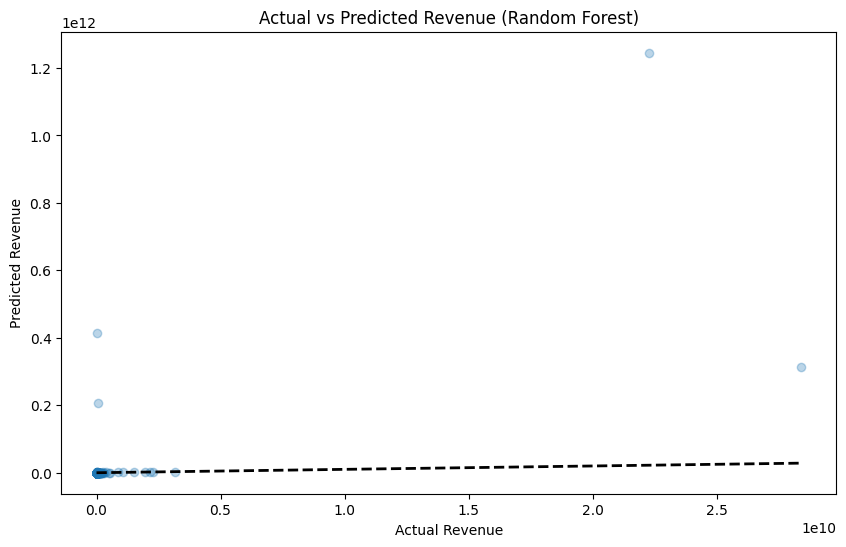

In [109]:
# Choose a model to visualize predictions (e.g., Random Forest)
chosen_model_name = 'Random Forest'
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', models[chosen_model_name])
])
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.xlabel('Actual Revenue')
plt.ylabel('Predicted Revenue')
plt.title(f'Actual vs Predicted Revenue ({chosen_model_name})')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.show()

# Clustering

In [57]:
print(rfm["FutureCLV"].quantile(q = [.25,.5,.75]))

0.25               0.0
0.50     918379.989271
0.75    5296524.549208
Name: FutureCLV, dtype: Float64


In [58]:
rfm["FutureCLV"].describe()

count                   3317.0
mean         3160453438.138519
std        179752873661.716003
min                        0.0
25%                        0.0
50%              918379.989271
75%             5296524.549208
max      10352548089152.097656
Name: FutureCLV, dtype: Float64

In [ ]:
# Transform FutureCLV into segments
quantiles = rfm['FutureCLV'].quantile([0.33, 0.66])
rfm['Future_CLV_segment'] = np.where(rfm['FutureCLV'] <= quantiles[0.33], 'Low',
                             np.where(rfm['FutureCLV'] <= quantiles[0.66], 'Mid', 'High'))

# Encode CLV segments
le = LabelEncoder()
rfm['Future_CLV_segment_encoded'] = le.fit_transform(rfm['Future_CLV_segment'])
rfm.head()

,CustomerID,Recency,Frequency,Density,Monetary,R_Score,F_Score,D_Score,M_Score,RFM_Score,...,profit_margin,CLV,FutureRevenue,FutureCLV,Recency_Frequency,Recency_Monetary,Frequency_Monetary,AvgTransactionValue,Future_CLV_segment,Future_CLV_segment_encoded
0,12346,226,2,0,0.0,4,1,1,1,411,...,0.0,0.0,0.0,0.0,452,0.0,0.0,0.0,Low,1
1,12347,30,124,1590,2790.86,2,4,4,4,244,...,279.086,18450770.772385,1519.14,12644064.742631,3720,83725.8,346066.64,22.506935,High,0
2,12348,149,28,2124,1487.24,4,2,4,4,424,...,148.724,23204070.681398,310.0,10179377.939394,4172,221598.76,41642.72,53.115714,High,0
3,12350,211,17,197,334.4,4,2,1,2,422,...,33.44,1932162.781689,0.0,0.0,3587,70558.4,5684.8,19.670588,Low,1
4,12352,163,48,188,601.18,4,3,1,3,433,...,60.118,2211708.601229,944.23,6028049.884406,7824,97992.34,28856.64,12.524583,High,0


In [ ]:
rfm['Future_CLV_segment_encoded'].value_counts()

Future_CLV_segment_encoded
1    1378
0    1143
2     839
Name: count, dtype: int64

In [ ]:
print(rfm.value_counts())

CustomerID  Recency  Frequency  Density  Monetary  R_Score  F_Score  D_Score  M_Score  RFM_Score  rfm_level  Segment  RFM_Segment            RF_Segment       AOV         profit_margin  CLV              FutureRevenue  FutureCLV        Recency_Frequency  Recency_Monetary  Frequency_Monetary  AvgTransactionValue  Future_CLV_segment  Future_CLV_segment_encoded
12346       226      2          0         0.0      4        1        1        1        411        6          Middle   Recent Customers       Promising         0.0         0.0           0.0              0.0            0.0              452                 0.0               0.0                 0.0                 Low                 1                             1
16298       87       7          50        114.3    3        1        1        1        311        5          Low      Still Got Hope         About to Sleep    16.328571   11.43         548219.547553    483.9          3720491.826087   609                 9944.1            800.1

In [ ]:
rfm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3360 entries, 0 to 3359
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   CustomerID                  3360 non-null   category
 1   Recency                     3360 non-null   int64   
 2   Frequency                   3360 non-null   int64   
 3   Density                     3360 non-null   Int64   
 4   Monetary                    3360 non-null   Float64 
 5   R_Score                     3360 non-null   int64   
 6   F_Score                     3360 non-null   int64   
 7   D_Score                     3360 non-null   int64   
 8   M_Score                     3360 non-null   int64   
 9   RFM_Score                   3360 non-null   category
 10  rfm_level                   3360 non-null   int64   
 11  Segment                     3360 non-null   category
 12  RFM_Segment                 3360 non-null   category
 13  RF_Segment        

In [ ]:
# Ensure 'RFM_Segment' is treated as a categorical variable
# rfm['RFM_Segment'] = rfm['RFM_Segment'].astype('category')

# Specify the categorical and numerical features
categorical_features = ['Segment', 'RF_Segment']  # Example other categorical features
numerical_features = ['Recency', 'Frequency', 'Density', 'Monetary', 'R_Score', 'F_Score', 'D_Score', 'M_Score',
                      'RFM_Score', 'AOV', 'profit_margin', 'CLV', 'FutureRevenue', 'Recency_Frequency',
                      'Recency_Monetary', 'Frequency_Monetary', 'AvgTransactionValue']

# Define the ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(with_mean=False), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

# Include customerID in the dataset for comparison later
X = rfm[numerical_features + categorical_features + ['CustomerID']]
y = rfm['Future_CLV_segment']

# Apply LabelEncoder to the target variable for XGBoost
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(rfm['Future_CLV_segment'])

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train_encoded, X_test_encoded, y_train_encoded, y_test_encoded = train_test_split(X, y_encoded, test_size=0.3, random_state=42)

# Separate the customerID from the features
X_train_features = X_train.drop(columns=['CustomerID'])
X_test_features = X_test.drop(columns=['CustomerID'])
customerID_test = X_test['CustomerID']

X_train_encoded_features = X_train_encoded.drop(columns=['CustomerID'])
X_test_encoded_features = X_test_encoded.drop(columns=['CustomerID'])
customerID_encoded_test = X_test_encoded['CustomerID']

# Define the models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Support Vector Classifier': SVC(),
    'Gradient Boost': GradientBoostingClassifier()
}

xgboost_model = {
    'XGBoost': XGBClassifier(use_label_encoder=False, enable_categorical=True, random_state=42, eval_metric='mlogloss')
}

model_performance = {}

# Train and evaluate models other than XGBoost
for model_name, model in models.items():
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])

    # Train the model
    pipeline.fit(X_train_features, y_train)

    # Predict on the test set
    y_pred = pipeline.predict(X_test_features)

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)

    # Perform cross-validation
    cv_scores = cross_val_score(pipeline, X_train_features, y_train, cv=5, scoring='accuracy')
    cv_mean = np.mean(cv_scores)

    # Store the performance
    model_performance[model_name] = {'Accuracy': accuracy, 'CV_Accuracy': cv_mean, 'Classification Report': report, 'Confusion Matrix': cm}

# Train and evaluate XGBoost
for model_name, model in xgboost_model.items():
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])

    # Train the model
    pipeline.fit(X_train_encoded_features, y_train_encoded)

    # Predict on the test set
    y_pred = pipeline.predict(X_test_encoded_features)

    # Evaluate the model
    accuracy = accuracy_score(y_test_encoded, y_pred)
    report = classification_report(y_test_encoded, y_pred)
    cm = confusion_matrix(y_test_encoded, y_pred)

    # Perform cross-validation
    cv_scores = cross_val_score(pipeline, X_train_encoded_features, y_train_encoded, cv=5, scoring='accuracy')
    cv_mean = np.mean(cv_scores)

    # Store the performance
    model_performance[model_name] = {'Accuracy': accuracy, 'CV_Accuracy': cv_mean, 'Classification Report': report, 'Confusion Matrix': cm}

# Display model performance
for model_name, metrics in model_performance.items():
    print(f"{model_name} - Accuracy: {metrics['Accuracy']}, CV_Accuracy: {metrics['CV_Accuracy']}")
    print(f"Classification Report:\n{metrics['Classification Report']}")
    print(f"Confusion Matrix:\n{metrics['Confusion Matrix']}")

# Save the best model (for example, XGBoost) to a file
best_model_cf = xgboost_model['XGBoost']
best_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', best_model_cf)
])
best_pipeline.fit(X_train_encoded_features, y_train_encoded)

# save the model
filename = 'best_model_classification.sav'
pickle.dump(best_model_cf, open(filename, 'wb'))

print("Best model saved as 'best_model_classification.pkl'")

Logistic Regression - Accuracy: 0.8422619047619048, CV_Accuracy: 0.8214310882233364
Classification Report:
              precision    recall  f1-score   support

        High       0.93      0.88      0.90       345
         Low       0.81      0.98      0.89       429
         Mid       0.77      0.54      0.63       234

    accuracy                           0.84      1008
   macro avg       0.84      0.80      0.81      1008
weighted avg       0.84      0.84      0.83      1008

Confusion Matrix:
[[302  13  30]
 [  0 420   9]
 [ 22  85 127]]
Random Forest - Accuracy: 0.9325396825396826, CV_Accuracy: 0.9302696842390568
Classification Report:
              precision    recall  f1-score   support

        High       0.92      0.90      0.91       345
         Low       0.99      1.00      0.99       429
         Mid       0.85      0.85      0.85       234

    accuracy                           0.93      1008
   macro avg       0.92      0.92      0.92      1008
weighted avg       0.

In [ ]:
X_train_encoded_features.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2352 entries, 2892 to 3174
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   Recency              2352 non-null   int64   
 1   Frequency            2352 non-null   int64   
 2   Density              2352 non-null   Int64   
 3   Monetary             2352 non-null   Float64 
 4   R_Score              2352 non-null   int64   
 5   F_Score              2352 non-null   int64   
 6   D_Score              2352 non-null   int64   
 7   M_Score              2352 non-null   int64   
 8   RFM_Score            2352 non-null   category
 9   AOV                  2352 non-null   Float64 
 10  profit_margin        2352 non-null   Float64 
 11  CLV                  2352 non-null   Float64 
 12  FutureRevenue        2352 non-null   Float64 
 13  Recency_Frequency    2352 non-null   int64   
 14  Recency_Monetary     2352 non-null   Float64 
 15  Frequency_Monetary   23

In [ ]:
X_encoded = label_encoder.fit_transform(rfm[['RFM_Score', 'Segment', 'RF_Segment']])
Column_costmr = rfm[['CustomerID']]
X_encoded.drop(Column_costmr, axis=1, inplace=True)

def train_model(X_encoded,y_encoded):
  model_xgb = XGBClassifier(learning_rate=0.01, max_depth=5)
  model_xgb.fit(X_encoded,y_encoded)
  return model_xgb
predict_model = train_model(X_encoded,y_encoded)

ValueError: y should be a 1d array, got an array of shape (3360, 3) instead.

# Prediction

In [ ]:
# Load the saved regression model
with open('best_model_regression.sav', 'rb') as file:
    loaded_regression_model = pickle.load(file)

# Prepare the new data
new_data = pd.DataFrame({
    'Recency': [10, 5],
    'Frequency': [50, 30],
    'Density': [0.1, 0.2],
    'Monetary': [5000, 3000],
    'R_Score': [4, 3],
    'F_Score': [3, 3],
    'D_Score': [3, 2],
    'M_Score': [4, 4],
    'RFM_Score': [434, 334],
    'rfm_level': [11, 10],  # Example levels
    'Segment': ['High', 'High'],
    'RFM_Segment': ['Champions', 'Potential Loyalist'],
    'RF_Segment': ['Loyal Customers', 'About to Sleep'],
    'AOV': [100, 150],
    'profit_margin': [2000, 1500],
    'CLV': [2500, 2000],
    'FutureRevenue': [3000, 2500],
    'FutureCLV': [2600, 2100],
    'Recency_Frequency': [20, 15],
    'Recency_Monetary': [250, 200],
    'Frequency_Monetary': [500, 400],
    'AvgTransactionValue': [50, 75],
})

# # Convert categorical columns to 'category' type
# categorical_columns = ['Segment', 'RF_Segment', 'RFM_Score']
# for col in categorical_columns:
#     new_data[col] = new_data[col].astype('category')

# Predict on new data using the loaded model
regression_predictions = loaded_regression_model.predict(new_data)

# Output the predictions
print("Regression Predictions:", regression_predictions)
new_data['Regression_Predictions'] = regression_predictions

Regression Predictions: [699089.18416016 699248.46788778]


In [ ]:
new_data[['Recency','Frequency','Density','Monetary','R_Score','F_Score','D_Score','M_Score','Regression_Predictions']]

,Recency,Frequency,Density,Monetary,R_Score,F_Score,D_Score,M_Score,Regression_Predictions
0,10,50,0.1,5000,4,3,3,4,699089.184160
1,5,30,0.2,3000,3,3,2,4,699248.467888


In [ ]:
# Example: Load the model and make predictions
with open('best_model_classification.sav', 'rb') as file:
    loaded_model = pickle.load(file)

# Prepare new data (example)
new_data2 = pd.DataFrame({
    'CustomerID': ['19981', '19979'],  # Placeholder IDs
    'Recency': [10, 5],
    'Frequency': [50, 30],
    'Density': [0.1, 0.2],
    'Monetary': [5000, 3000],
    'R_Score': [4, 3],
    'F_Score': [3, 3],
    'D_Score': [3, 2],
    'M_Score': [4, 4],
    'RFM_Score': [434, 334],
    'rfm_level': [11, 10],  # Example levels
    'Segment': ['High', 'High'],
    'RFM_Segment': ['Champions', 'Potential Loyalist'],
    'RF_Segment': ['Loyal Customers', 'About to Sleep'],
    'AOV': [100, 150],
    'profit_margin': [2000, 1500],
    'CLV': [2500, 2000],
    'FutureRevenue': [3000, 2500],
    'FutureCLV': [2600, 2100],
    'Recency_Frequency': [20, 15],
    'Recency_Monetary': [250, 200],
    'Frequency_Monetary': [500, 400],
    'AvgTransactionValue': [50, 75],
    'Future_CLV_segment': ['Mid', 'Low'],  # Example segments
    'Future_CLV_segment_encoded': [1, 0]   # Example encoded segments
})

# Ubah kolom kategori menjadi tipe category
categorical_columns = ['rfm_level', 'Segment', 'RFM_Segment', 'RF_Segment', 'Future_CLV_segment', 'CustomerID']

for col in categorical_columns:
    new_data2[col] = new_data2[col].astype('category')

# Drop 'CustomerID' dan 'Future_CLV_segment' columns for prediction
new_data_features = new_data2

# Pastikan urutan kolom sesuai dengan data pelatihan
numerical_features = ['Recency', 'Frequency', 'Density', 'Monetary', 'R_Score', 'F_Score', 'D_Score', 'M_Score',
                      'RFM_Score', 'AOV', 'profit_margin', 'CLV', 'FutureRevenue', 'FutureCLV', 'Recency_Frequency',
                      'Recency_Monetary', 'Frequency_Monetary', 'AvgTransactionValue']
categorical_features = ['Segment', 'RF_Segment', 'rfm_level', 'RFM_Segment']
all_features = numerical_features + categorical_features + ['Future_CLV_segment_encoded']

new_data_features = new_data_features[all_features]

# Ensure enable_categorical=True is set in the model
loaded_model.set_params(enable_categorical=True)

# Ensure the new data goes through the same preprocessing pipeline
predictions = loaded_model.predict(new_data2)

In [ ]:
new_data2['CLV_Segment_Predictions'] = predictions
new_data2

,CustomerID,Recency,Frequency,Density,Monetary,R_Score,F_Score,D_Score,M_Score,RFM_Score,...,CLV,FutureRevenue,FutureCLV,Recency_Frequency,Recency_Monetary,Frequency_Monetary,AvgTransactionValue,Future_CLV_segment,Future_CLV_segment_encoded,CLV_Segment_Predictions
0,19981,10,50,0.1,5000,4,3,3,4,434,...,2500,3000,2600,20,250,500,50,Mid,1,1
1,19979,5,30,0.2,3000,3,3,2,4,334,...,2000,2500,2100,15,200,400,75,Low,0,0


In [ ]:
new_data2[['Recency','Frequency','Density','Monetary','R_Score','F_Score','D_Score','M_Score','CLV_Segment_Predictions']]

,Recency,Frequency,Density,Monetary,R_Score,F_Score,D_Score,M_Score,CLV_Segment_Predictions
0,10,50,0.1,5000,4,3,3,4,1
1,5,30,0.2,3000,3,3,2,4,0


# VISUALIZATION

In [ ]:
!pip install squarify
import squarify

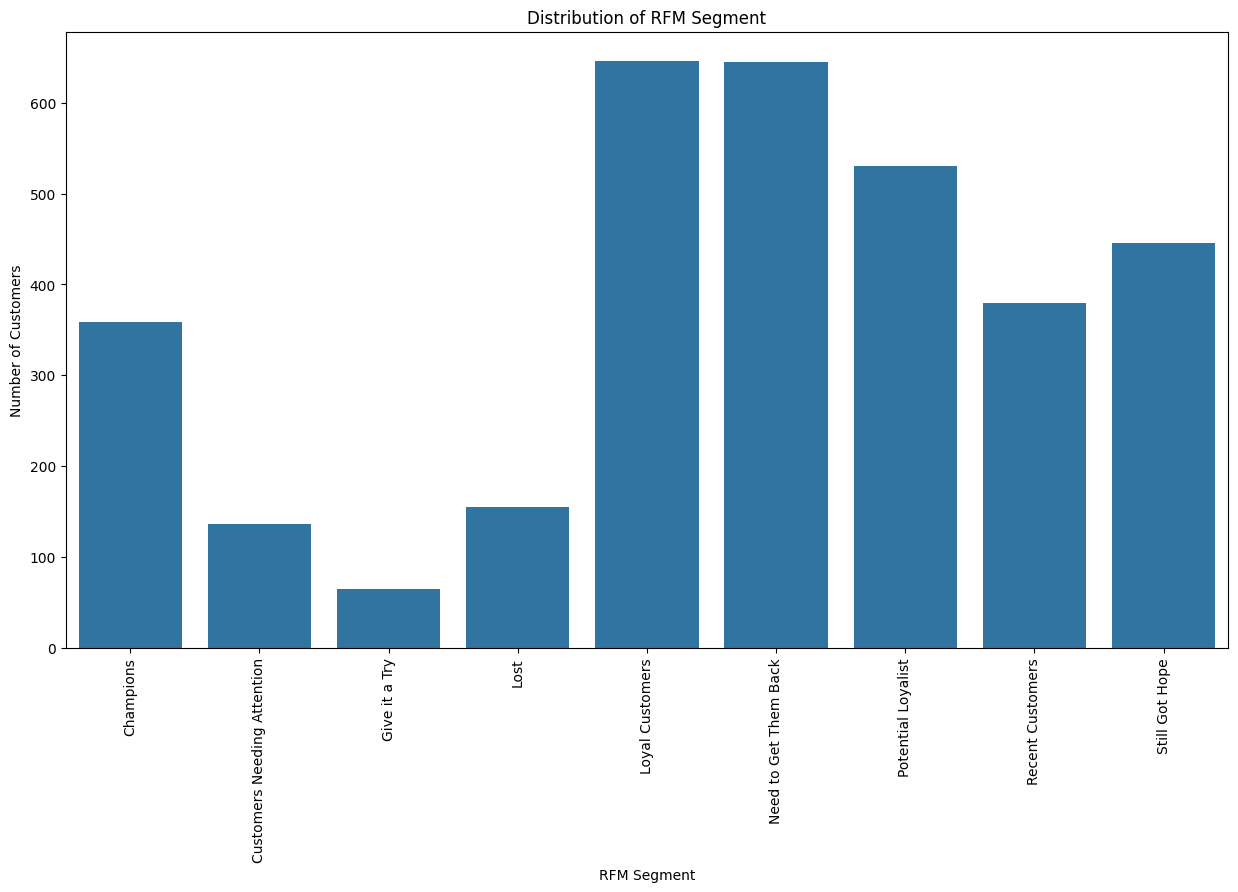

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

rfm_score_counts = rfm['RFM_Segment'].value_counts().reset_index()
rfm_score_counts.columns = ['RFM_Segment', 'Count']

# Plot the distribution of RFM scores
plt.figure(figsize=(15, 8))
sns.barplot(x='RFM_Segment', y='Count', data=rfm_score_counts)
plt.title('Distribution of RFM Segment')
plt.xlabel('RFM Segment')
plt.ylabel('Number of Customers')
plt.xticks(rotation=90)  # Rotate x-axis labels if needed
plt.show()

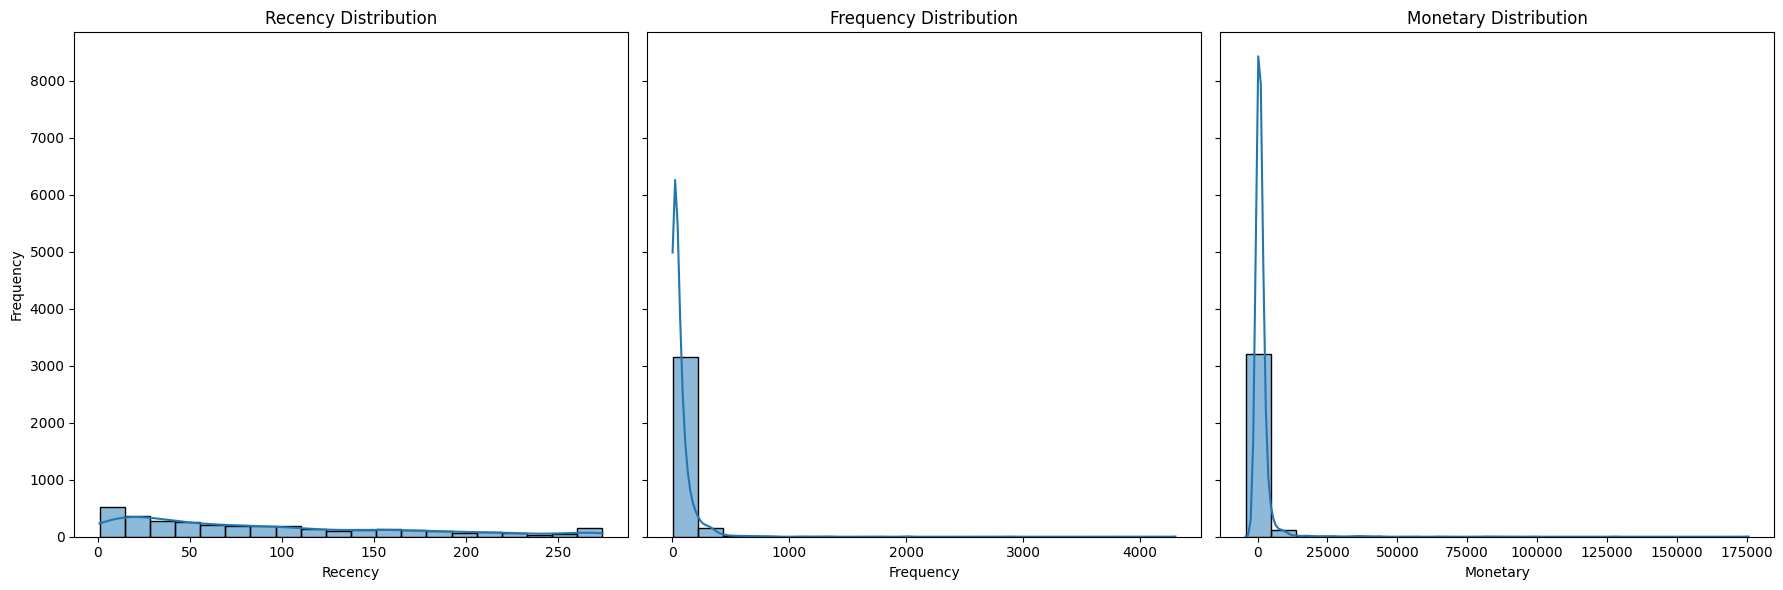

In [ ]:
# Plot the distribution of Recency, Frequency, and Monetary scores
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

sns.histplot(rfm['Recency'], bins=20, kde=True, ax=axes[0])
axes[0].set_title('Recency Distribution')
axes[0].set_xlabel('Recency')
axes[0].set_ylabel('Frequency')

sns.histplot(rfm['Frequency'], bins=20, kde=True, ax=axes[1])
axes[1].set_title('Frequency Distribution')
axes[1].set_xlabel('Frequency')

sns.histplot(rfm['Monetary'], bins=20, kde=True, ax=axes[2])
axes[2].set_title('Monetary Distribution')
axes[2].set_xlabel('Monetary')

plt.tight_layout()
plt.show()

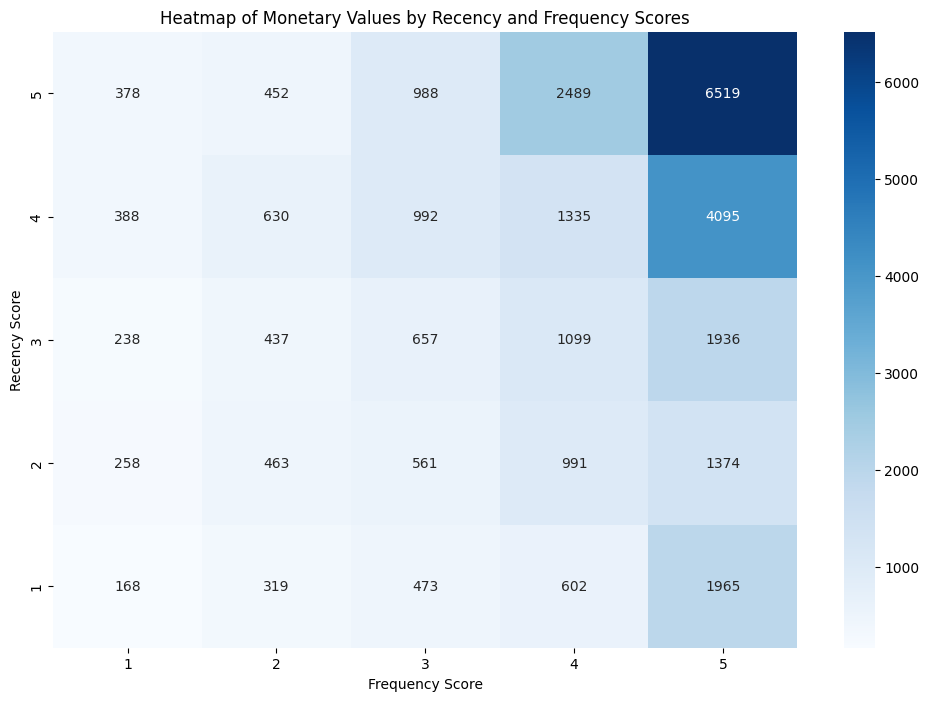

In [ ]:
# Create a pivot table for Recency and Frequency
rfm_pivot = rfm.pivot_table(index='R_Score', columns='F_Score', values='Monetary', aggfunc='mean').fillna(0)

# Ensure all data in the pivot table is numeric
rfm_pivot = rfm_pivot.applymap(lambda x: pd.to_numeric(x, errors='coerce')).fillna(0)

# Plot a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(rfm_pivot, annot=True, fmt='.0f', cmap='Blues')
plt.title('Heatmap of Monetary Values by Recency and Frequency Scores')
plt.xlabel('Frequency Score')
plt.ylabel('Recency Score')
plt.show()

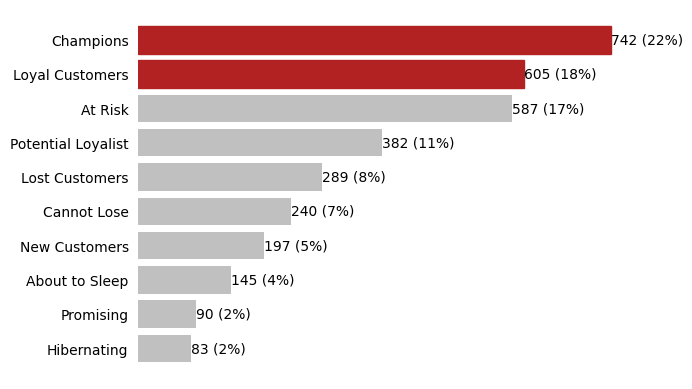

In [ ]:
# count the number of customers in each segment
segments_counts = rfm['RFM_Segment'].value_counts().sort_values(ascending=True)

fig, ax = plt.subplots()

bars = ax.barh(range(len(segments_counts)),
              segments_counts,
              color='silver')
ax.set_frame_on(False)
ax.tick_params(left=False,
               bottom=False,
               labelbottom=False)
ax.set_yticks(range(len(segments_counts)))
ax.set_yticklabels(segments_counts.index)

for i, bar in enumerate(bars):
        value = bar.get_width()
        if segments_counts.index[i] in ['Champions', 'Loyal Customers']:
            bar.set_color('firebrick')
        ax.text(value,
                bar.get_y() + bar.get_height()/2,
                '{:,} ({:}%)'.format(int(value),
                                   int(value*100/segments_counts.sum())),
                va='center',
                ha='left'
               )

plt.show()

In [ ]:
# Calculate average values for each RFM segment, and return a size of each segment
rfm_vis = rfm.groupby('RFM_Segment').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': ['mean', 'count'],
}).round(1)
# Print the aggregated dataset
rfm_vis

Recency Frequency Monetary      
                      mean      mean     mean count
RFM_Segment                                        
About to Sleep       131.4      11.3    119.3   145
At Risk              167.6      27.4    500.7   587
Cannot Lose          152.7      75.2   1147.8   240
Champions             19.7     183.9   4456.0   742
Hibernating          171.6       7.0    266.3    83
Lost Customers       224.3      10.9     97.1   289
Loyal Customers       51.2      72.2   1180.0   605
New Customers         50.3       6.2    101.6   197
Potential Loyalist    47.7      26.5    302.2   382
Promising             41.7      11.8   1406.7    90

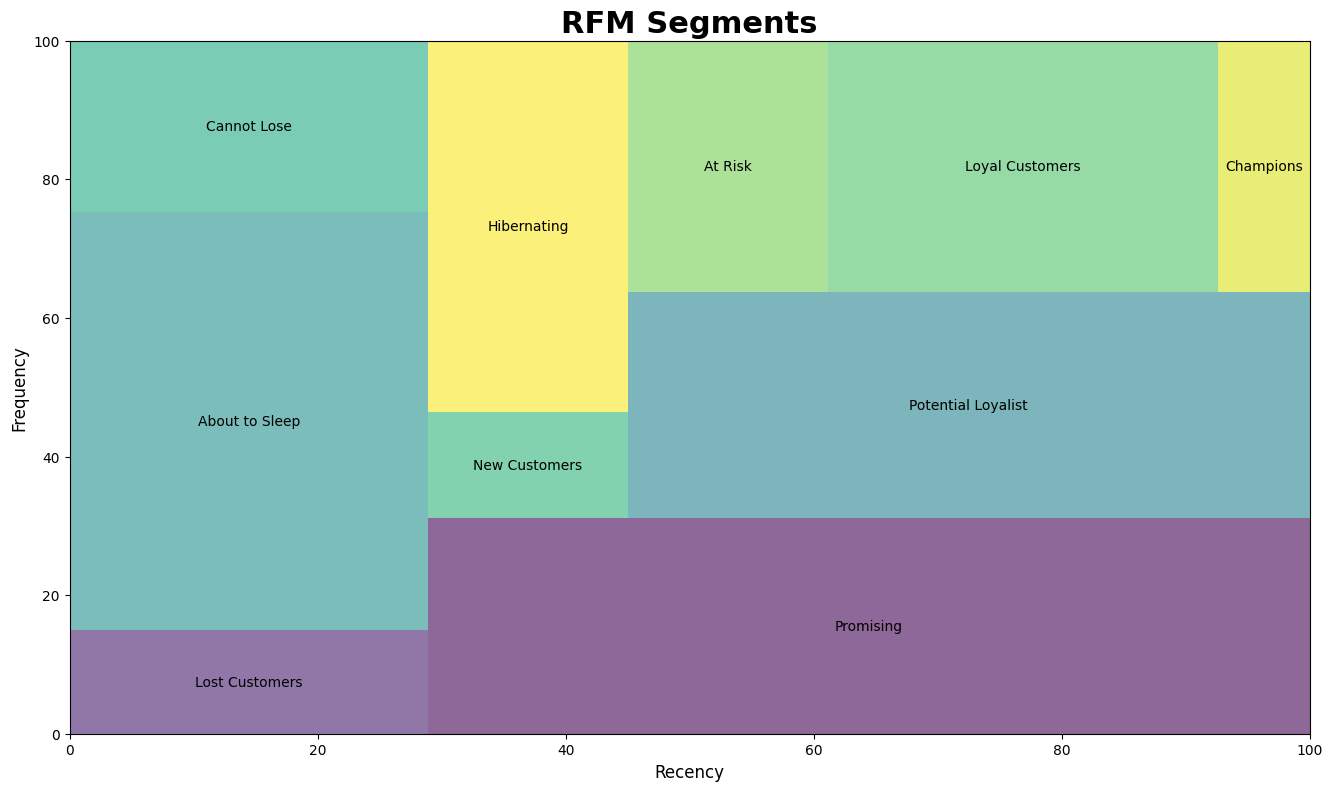

In [ ]:
# Assuming rfm_vis has been created previously and has the correct values

# Rename columns for clarity
rfm_vis.columns = ['Recencymean', 'Frequencymean', 'Monetarymean', 'Count']

# Set up the plot
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(16, 9)

# Correct labels with missing comma
squarify.plot(sizes=rfm_vis['Count'],
              label=['Lost Customers',
                     'About to Sleep',
                     'Cannot Lose',
                     'Promising',
                     'New Customers',
                     'Hibernating',
                     'Potential Loyalist',
                     'At Risk',
                     'Loyal Customers',
                     'Champions'],
              alpha=.6)

# Add title and axis labels
plt.title("RFM Segments", fontsize=22, fontweight="bold")
ax.set_xlabel('Recency', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
plt.axis('on')

# Show the plot
plt.show()